# 神经网络长什么样不知道?这有一份简单的 pytorch 可视化技巧
深度学习这几年伴随着硬件性能的进一步提升,人们开始着手于设计更深更复杂的神经网络,有时候我们在开源社区拿到网络模型的时候,做客可能 不会直接开源模型代码,而是给出一个模型的参数文件,当我们想要复现算法的时候,很可能就需要靠自己手动仿造源作者设计的神经网络进行搭建,为了方便我们设计网络,我结合了我最近的工作积累,给大家分享一些关于 pytorch 的网络可视化方法


# pytorch-summary
https://github.com/sksq96/pytorch-summary
最简单的 pytorch 网络结构打印方法,也是最不依赖各种环境的一个轻量级可视化网络结构pytorch 扩展包
类似于Keras style的model.summary()
以前用过Keras的朋友应该见过,Keras有一个简洁的API来查看模型的可视化，这在调试网络时非常有用。这是一个准备在PyTorch中模仿相同的准系统代码。目的是提供补充信息，以及PyTorch中print（your_model）未提供的信息。

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch
import torch.nn as nn

In [5]:
class UNet(nn.Module):
	"""Custom U-Net architecture for Noise2Noise (see Appendix, Table 2)."""

	def __init__(self, in_channels=3, out_channels=3):
		"""Initializes U-Net."""

		super(UNet, self).__init__()

		# Layers: enc_conv0, enc_conv1, pool1
		self._block1 = nn.Sequential(
			SpectralNorm(nn.Conv2d(in_channels, 24, 3, stride=1, padding=1)),
			nn.ReLU(inplace=True),
			SpectralNorm(nn.Conv2d(24, 24, 3, padding=1)),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(2))

		# Layers: enc_conv(i), pool(i); i=2..5
		self._block2 = nn.Sequential(
			SpectralNorm(nn.Conv2d(24, 24, 3, stride=1, padding=1)),
			nn.ReLU(inplace=True),
			nn.MaxPool2d(2))

		# Layers: enc_conv6, upsample5
		self._block3 = nn.Sequential(
			SpectralNorm (nn.Conv2d(24, 24, 3, stride=1, padding=1)),
			nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
			SpectralNorm(nn.Conv2d(24, 24, 3, stride=1, padding=1)))
			#nn.Upsample(scale_factor=2, mode='nearest'))

		# Layers: dec_conv5a, dec_conv5b, upsample4
		self._block4 = nn.Sequential(
			SpectralNorm(nn.Conv2d(48, 48, 3, stride=1, padding=1)),
			nn.ReLU(inplace=True),
			SpectralNorm(nn.Conv2d(48, 48, 3, stride=1, padding=1)),
			nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
			SpectralNorm(nn.Conv2d(48, 48, 3, stride=1, padding=1)))
			#nn.Upsample(scale_factor=2, mode='nearest'))

		# Layers: dec_deconv(i)a, dec_deconv(i)b, upsample(i-1); i=4..2
		self._block5 = nn.Sequential(
			SpectralNorm(nn.Conv2d(72, 48, 3, stride=1, padding=1)),
			nn.ReLU(inplace=True),
			SpectralNorm(nn.Conv2d(48, 48, 3, stride=1, padding=1)),
			nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
			SpectralNorm(nn.Conv2d(48, 48, 3, stride=1, padding=1)),
            )
			#nn.Upsample(scale_factor=2, mode='nearest'))

		# Layers: dec_conv1a, dec_conv1b, dec_conv1c,
		self._block6 = nn.Sequential(
			SpectralNorm(nn.Conv2d(48 + in_channels, 64, 3, stride=1, padding=1)),
			nn.ReLU(inplace=True),
			SpectralNorm(nn.Conv2d(64, 16, 3, stride=1, padding=1)),
			nn.ReLU(inplace=True),
			SpectralNorm(nn.Conv2d(16, out_channels, 3, stride=1, padding=1)),
			nn.LeakyReLU(0.2))

		# Initialize weights
		self._init_weights()


	def _init_weights(self):
		"""Initializes weights using He et al. (2015)."""

		for m in self.modules():
			if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight.data)
				m.bias.data.zero_()


	def forward(self, x):
		"""Through encoder, then decoder by adding U-skip connections. """

		# Encoder
		pool1 = self._block1(x)
		pool2 = self._block2(pool1)
		pool3 = self._block2(pool2)
		pool4 = self._block2(pool3)
		pool5 = self._block2(pool4)

		# Decoder
		upsample5 = self._block3(pool5)
		concat5 = torch.cat((upsample5, pool4), dim=1)
		upsample4 = self._block4(concat5)
		concat4 = torch.cat((upsample4, pool3), dim=1)
		upsample3 = self._block5(concat4)
		concat3 = torch.cat((upsample3, pool2), dim=1)
		upsample2 = self._block5(concat3)
		concat2 = torch.cat((upsample2, pool1), dim=1)
		upsample1 = self._block5(concat2)
		concat1 = torch.cat((-1*upsample1, x), dim=1)

		# Final activation
		return self._block6(concat1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = UNet().to(device)

summary(model, (3,256,256))


NameError: name 'SpectralNorm' is not defined

In [3]:
# import torch
# from torchvision import models
# from torchsummary import summary

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vgg = models.vgg11_bn().to(device)
# summary(vgg, (3, 224, 224))

device =  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 512, 512]             672
              ReLU-2         [-1, 24, 512, 512]               0
            Conv2d-3         [-1, 24, 512, 512]           5,208
              ReLU-4         [-1, 24, 512, 512]               0
         MaxPool2d-5         [-1, 24, 256, 256]               0
            Conv2d-6         [-1, 24, 256, 256]           5,208
              ReLU-7         [-1, 24, 256, 256]               0
         MaxPool2d-8         [-1, 24, 128, 128]               0
            Conv2d-9         [-1, 24, 128, 128]           5,208
             ReLU-10         [-1, 24, 128, 128]               0
        MaxPool2d-11           [-1, 24, 64, 64]               0
           Conv2d-12           [-1, 24, 64, 64]           5,208
             ReLU-13           [-1, 24, 64, 64]               0
        MaxPool2d-14    

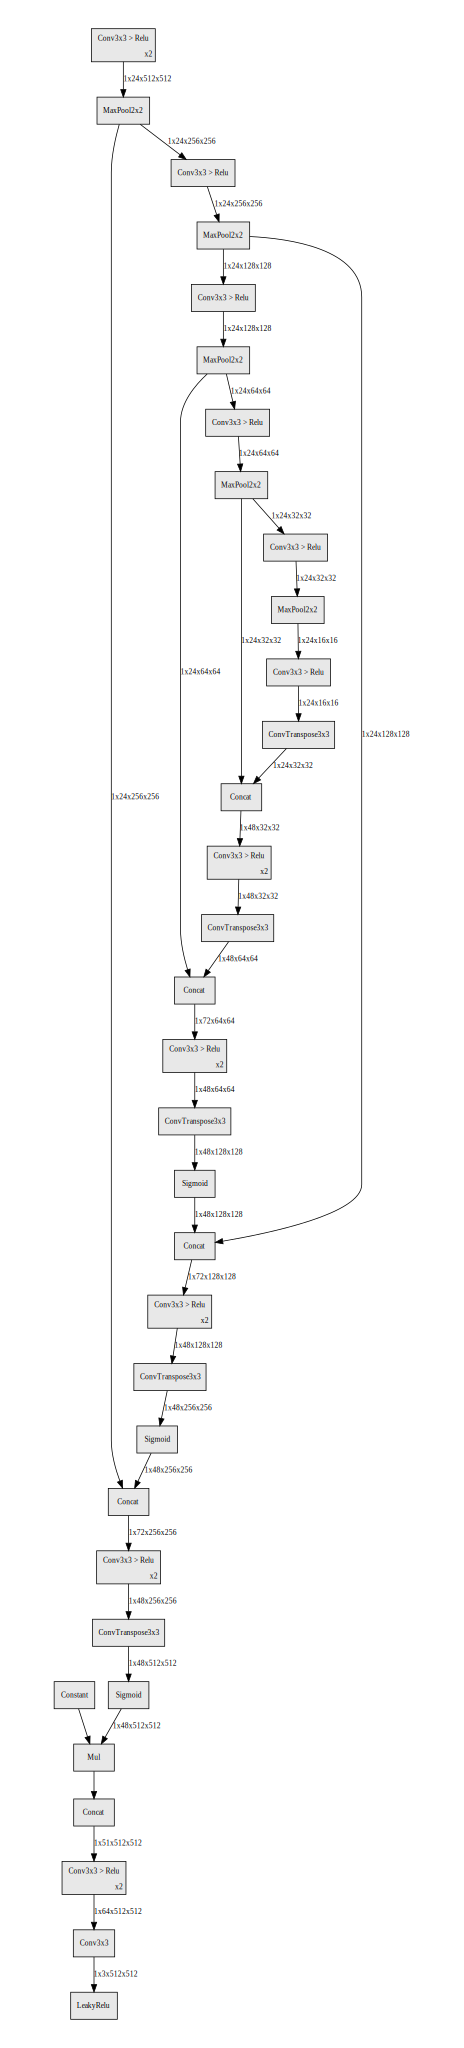

In [4]:
import torch
import torchvision.models
import hiddenlayer as hl
import cv2

# VGG16 with BatchNorm
device = torch.device("cuda")
print("device = ", device)
model = UNet()
model = model.cuda()

# Build HiddenLayer graph
# Jupyter Notebook renders it automatically
img=hl.build_graph(model, torch.zeros([1,3, 512, 512]).cuda())
summary(model,(3,512,512))
img

In [9]:
# img.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
# img.save("./vgg11bn.jpg")

In [11]:
# Resnet101
device = torch.device("cuda")
print("device = ", device)
model = torchvision.models.resnet152().cuda()

# Rather than using the default transforms, build custom ones to group
# nodes of residual and bottleneck blocks.
transforms = [
    # Fold Conv, BN, RELU layers into one
    hl.transforms.Fold("Conv > BatchNorm > Relu", "ConvBnRelu"),
    # Fold Conv, BN layers together
    hl.transforms.Fold("Conv > BatchNorm", "ConvBn"),
    # Fold bottleneck blocks
    hl.transforms.Fold("""
        ((ConvBnRelu > ConvBnRelu > ConvBn) | ConvBn) > Add > Relu
        """, "BottleneckBlock", "Bottleneck Block"),
    # Fold residual blocks
    hl.transforms.Fold("""ConvBnRelu > ConvBnRelu > ConvBn > Add > Relu""",
                       "ResBlock", "Residual Block"),
    # Fold repeated blocks
    hl.transforms.FoldDuplicates(),
]

# Display graph using the transforms above
hl.build_graph(model, torch.zeros([1, 3, 224, 224]).cuda(), transforms=transforms)



device =  cuda


RuntimeError: size mismatch, m1: [1 x 204800], m2: [2048 x 1000] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:266

In [17]:
import os
import time
import random
import numpy as np
import torch
import torchvision.models
import torch.nn as nn
from torchvision import datasets, transforms
import hiddenlayer as hl

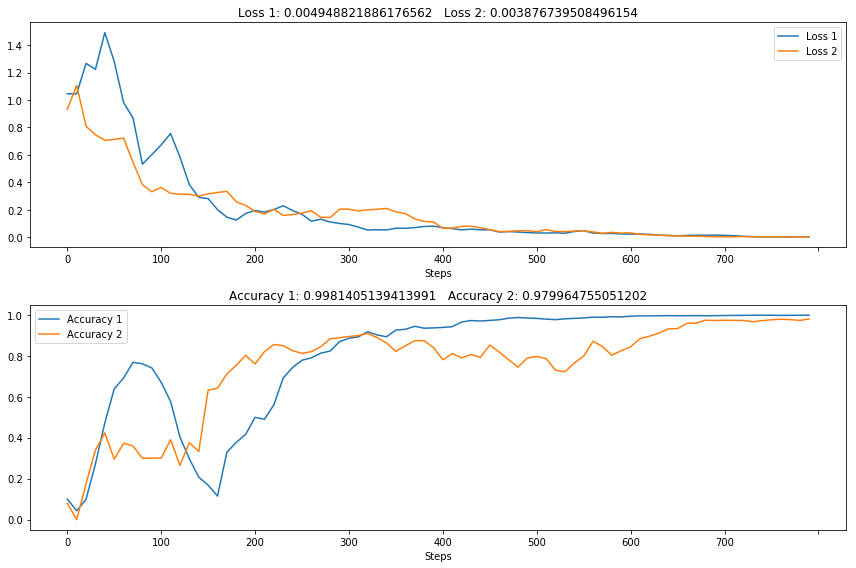

In [37]:
# A History object to store metrics
history1 = hl.History()

# A Canvas object to draw the metrics
canvas1 = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(800):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        # Store metrics in the history object
        history1.log(step, loss=loss, accuracy=accuracy)

        # Plot the two metrics in one graph
        canvas1.draw_plot([history1["loss"], history1["accuracy"]])

        time.sleep(0.1)
# New history and canvas objects
history2 = hl.History()
canvas2 = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(800):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        history2.log(step, loss=loss, accuracy=accuracy)

        # Draw two plots
        # Encluse them in a "with" context to ensure they render together
        with canvas2:
            canvas2.draw_plot([history1["loss"], history2["loss"]],
                              labels=["Loss 1", "Loss 2"])
            canvas2.draw_plot([history1["accuracy"], history2["accuracy"]],
                              labels=["Accuracy 1", "Accuracy 2"])
        time.sleep(0.1)

In [34]:

# Save experiments 1 and 2
history1.save("experiment1.pkl")
history2.save("experiment2.pkl")
# Load them again. To verify it's working, load them into new objects.
h1 = hl.History()
h2 = hl.History()
h1.load("experiment1.pkl")
h2.load("experiment2.pkl")

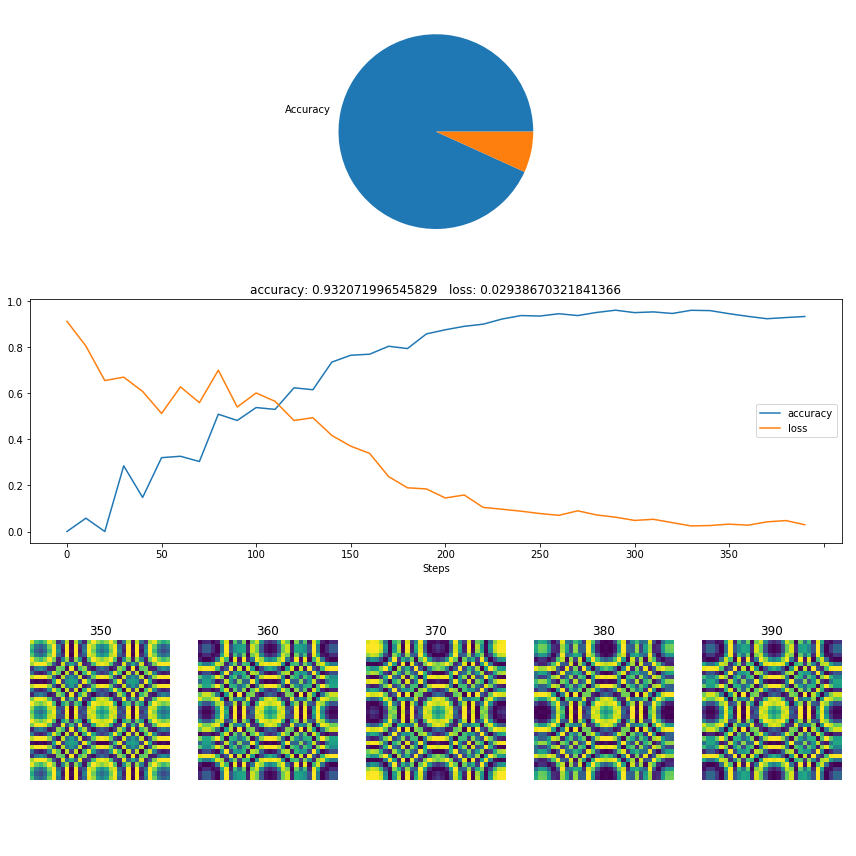

In [39]:
class MyCanvas(hl.Canvas):
    """Extending Canvas to add a pie chart method."""
    
    def draw_pie(self, metric):
        # Method name must start with 'draw_' for the Canvas to automatically manage it
        
        # Use the provided matplotlib Axes in self.ax
        self.ax.axis('equal')  # set square aspect ratio

        # Get latest value of the metric
        value = np.clip(metric.data[-1], 0, 1)
        
        # Draw pie chart
        self.ax.pie([value, 1-value], labels=["Accuracy", ""])
history3 = hl.History()
canvas3 = MyCanvas()  # My custom Canvas

# Simulate a training loop
loss = 1
accuracy = 0
for step in range(400):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    if step % 10 == 0:
        # Log loss and accuracy
        history3.log(step, loss=loss, accuracy=accuracy)

        # Log a fake image metric (e.g. image generated by a GAN)
        image = np.sin(np.sum(((np.indices([32, 32]) - 16) * 0.5 * accuracy) ** 2, 0))
        history3.log(step, image=image)
        
        # Display
        with canvas3:
            canvas3.draw_pie(history3["accuracy"])
            canvas3.draw_plot([history3["accuracy"], history3["loss"]])
            canvas3.draw_image(history3["image"])

        time.sleep(0.1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,320
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
         MaxPool2d-7           [-1, 16, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           4,640
       BatchNorm2d-9           [-1, 32, 16, 16]              64
             ReLU-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
      BatchNorm2d-12           [-1, 32, 16, 16]              64
             ReLU-13           [-1, 32, 16, 16]               0
        MaxPool2d-14             [-1, 3

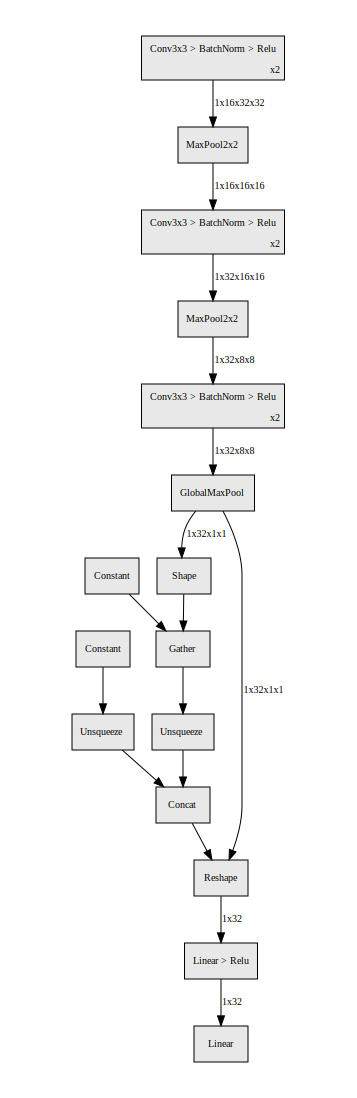

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import argparse
# Simple Convolutional Network
class CifarModel(nn.Module):
    def __init__(self):
        super(CifarModel, self).__init__()
        self.c2d=nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.features = nn.Sequential(
            
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.AdaptiveMaxPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32, 32),
#             TODO: nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Linear(32, 10))

    def forward(self, x):
        x_0=self.c2d(x)
        x1 = self.features(x_0)
        self.feature_map=x_0
        x2 = x1.view(x1.size(0), -1)
        x3 = self.classifier(x2)
        return x3

model = CifarModel().cuda()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#show parameter
summary(model, (3, 32, 32))

hl.build_graph(model,torch.zeros([1,3,32,32]).cuda())

In [10]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


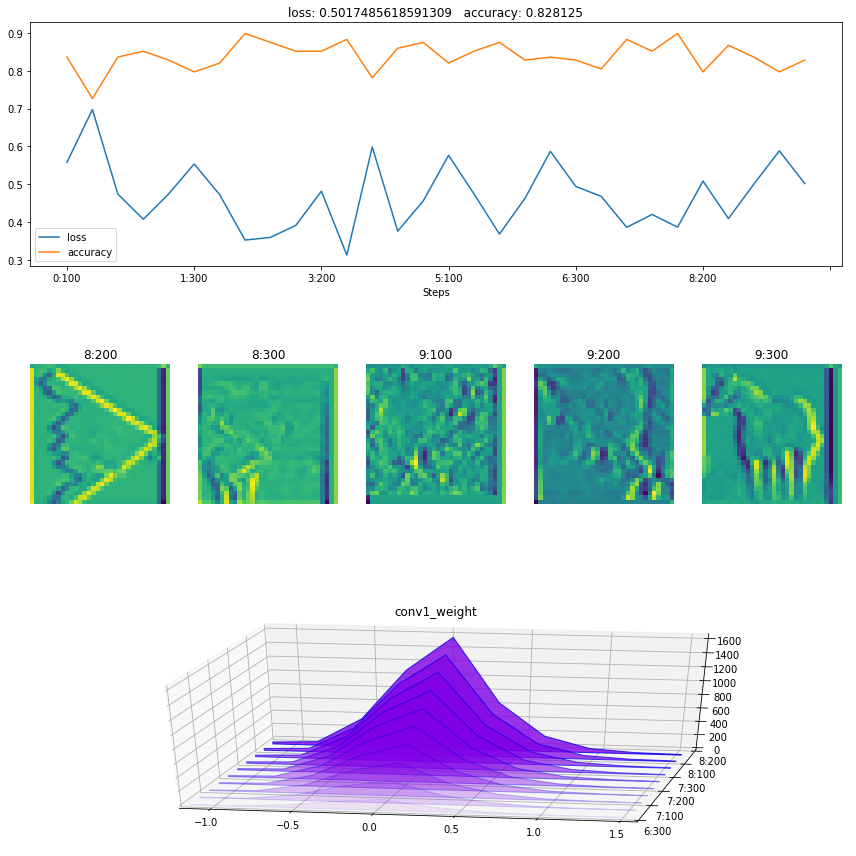

In [17]:

step = (0, 0)  # tuple of (epoch, batch_ix)
cifar_history = hl.History()
cifar_canvas = hl.Canvas()

# Training loop
for epoch in range(10):
    train_iter = iter(trainloader)
    for batch_ix, (inputs, labels) in enumerate(train_iter):
        # Update global step counter
        step = (epoch, batch_ix)

        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        if batch_ix and batch_ix % 100 == 0:
            # Compute accuracy
            pred_labels = np.argmax(outputs.detach().cpu().numpy(), 1)
            accuracy = np.mean(pred_labels == labels.detach().cpu().numpy())
            # Log metrics to history
            cifar_history.log((epoch, batch_ix),
                              loss=loss, accuracy=accuracy,
                              conv1_weight=model.c2d.weight,
                              feature_map=model.feature_map[0,1].detach().cpu().numpy())
            # Visualize metrics
            with cifar_canvas:
                cifar_canvas.draw_plot([cifar_history["loss"], cifar_history["accuracy"]])
                cifar_canvas.draw_image(cifar_history["feature_map"])
                cifar_canvas.draw_hist(cifar_history["conv1_weight"])